<a href="https://colab.research.google.com/github/itswwong/csm148-project/blob/main/CS148_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Data Set Explanation

Our team selected the Sleep Health and Lifestyle Dataset, which contains information about individuals’ demographics, daily habits, physical health, and sleep patterns.

## 2. Main Features

We are studying how Stress, Activity, Steps, HR, BP, BMI, Age, Gender, and Occupation affect Quality of Sleep.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

df = pd.read_csv('data/dataset.csv')

df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


## 3. Data Cleaning

In [2]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})

# Check for duplicate rows
duplicates = df.duplicated().sum()

In [3]:
# Replace "Normal Weight" with "Normal" in the original dataset
df['BMI Category'] = df['BMI Category'].replace('Normal Weight', 'Normal')

In [4]:
# Create copy for cleaning
df_clean = df.copy()

# Split blood pressure into systolic and diastolic
bp_split = df_clean['Blood Pressure'].str.split('/', expand=True)
df_clean['Systolic_BP'] = pd.to_numeric(bp_split[0])
df_clean['Diastolic_BP'] = pd.to_numeric(bp_split[1])

# Create catagories based on blood pressure levels

def catagorize_bp(row):
    systolic = row['Systolic_BP']
    diastolic = row['Diastolic_BP']

    if systolic < 120 and diastolic < 80:
        return 'Normal'
    elif 120 <= systolic < 130 and diastolic < 80:
        return 'Elevated'
    elif (130 <= systolic < 140) and (80 <= diastolic < 90):
        return 'Hypertension Stage 1'
    else:
        return 'Hypertension Stage 2'

df_clean['Blood_Pressure_Level'] = df_clean.apply(catagorize_bp, axis=1)
print(df_clean['Blood_Pressure_Level'].value_counts())

# 2. Create binary variables for sleep disorders
df_clean['Has_Sleep_Disorder'] = (df_clean['Sleep Disorder'] != 'None').astype(int)
df_clean['Has_Insomnia'] = (df_clean['Sleep Disorder'] == 'Insomnia').astype(int)
df_clean['Has_Sleep_Apnea'] = (df_clean['Sleep Disorder'] == 'Sleep Apnea').astype(int)

# 3. Create BMI numeric variable (for easier analysis)
bmi_mapping = {
    'Normal': 1,
    'Overweight': 2,
    'Obese': 3
}
df_clean['BMI_Numeric'] = df_clean['BMI Category'].map(bmi_mapping)

# 4. Create age groups for better analysis
df_clean['Age_Group'] = pd.cut(df_clean['Age'],
                               bins=[0, 30, 40, 50, 100],
                               labels=['Young Adult', 'Adult', 'Middle Age', 'Senior'])

# 5. Create physical activity level categories
df_clean['Activity_Level'] = pd.cut(df_clean['Physical Activity Level'],
                                   bins=[0, 30, 60, 100],
                                   labels=['Low', 'Moderate', 'High'])

df_clean.describe(include='all')

Blood_Pressure_Level
Hypertension Stage 2    224
Hypertension Stage 1    108
Normal                   41
Elevated                  1
Name: count, dtype: int64


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,...,Sleep Disorder,Systolic_BP,Diastolic_BP,Blood_Pressure_Level,Has_Sleep_Disorder,Has_Insomnia,Has_Sleep_Apnea,BMI_Numeric,Age_Group,Activity_Level
count,374.000000,374,374.000000,374,374.000000,374.000000,374.000000,374.000000,374,374,...,155,374.000000,374.000000,374,374.0,374.000000,374.000000,374.000000,374,374
unique,NaN,2,NaN,11,NaN,NaN,NaN,NaN,3,25,...,2,NaN,NaN,4,NaN,NaN,NaN,NaN,4,3
top,NaN,Male,NaN,Nurse,NaN,NaN,NaN,NaN,Normal,130/85,...,Sleep Apnea,NaN,NaN,Hypertension Stage 2,NaN,NaN,NaN,NaN,Adult,Moderate
freq,NaN,189,NaN,73,NaN,NaN,NaN,NaN,216,99,...,78,NaN,NaN,224,NaN,NaN,NaN,NaN,133,163
mean,187.500000,NaN,42.184492,NaN,7.132086,7.312834,59.171123,5.385027,NaN,NaN,...,NaN,128.553476,84.649733,NaN,1.0,0.205882,0.208556,1.449198,NaN,NaN
std,108.108742,NaN,8.673133,NaN,0.795657,1.196956,20.830804,1.774526,NaN,NaN,...,NaN,7.748118,6.161611,NaN,0.0,0.404887,0.406821,0.549274,NaN,NaN
min,1.000000,NaN,27.000000,NaN,5.800000,4.000000,30.000000,3.000000,NaN,NaN,...,NaN,115.000000,75.000000,NaN,1.0,0.000000,0.000000,1.000000,NaN,NaN
25%,94.250000,NaN,35.250000,NaN,6.400000,6.000000,45.000000,4.000000,NaN,NaN,...,NaN,125.000000,80.000000,NaN,1.0,0.000000,0.000000,1.000000,NaN,NaN
50%,187.500000,NaN,43.000000,NaN,7.200000,7.000000,60.000000,5.000000,NaN,NaN,...,NaN,130.000000,85.000000,NaN,1.0,0.000000,0.000000,1.000000,NaN,NaN
75%,280.750000,NaN,50.000000,NaN,7.800000,8.000000,75.000000,7.000000,NaN,NaN,...,NaN,135.000000,90.000000,NaN,1.0,0.000000,0.000000,2.000000,NaN,NaN


## 4. Exploratory Data Analysis (EDA)

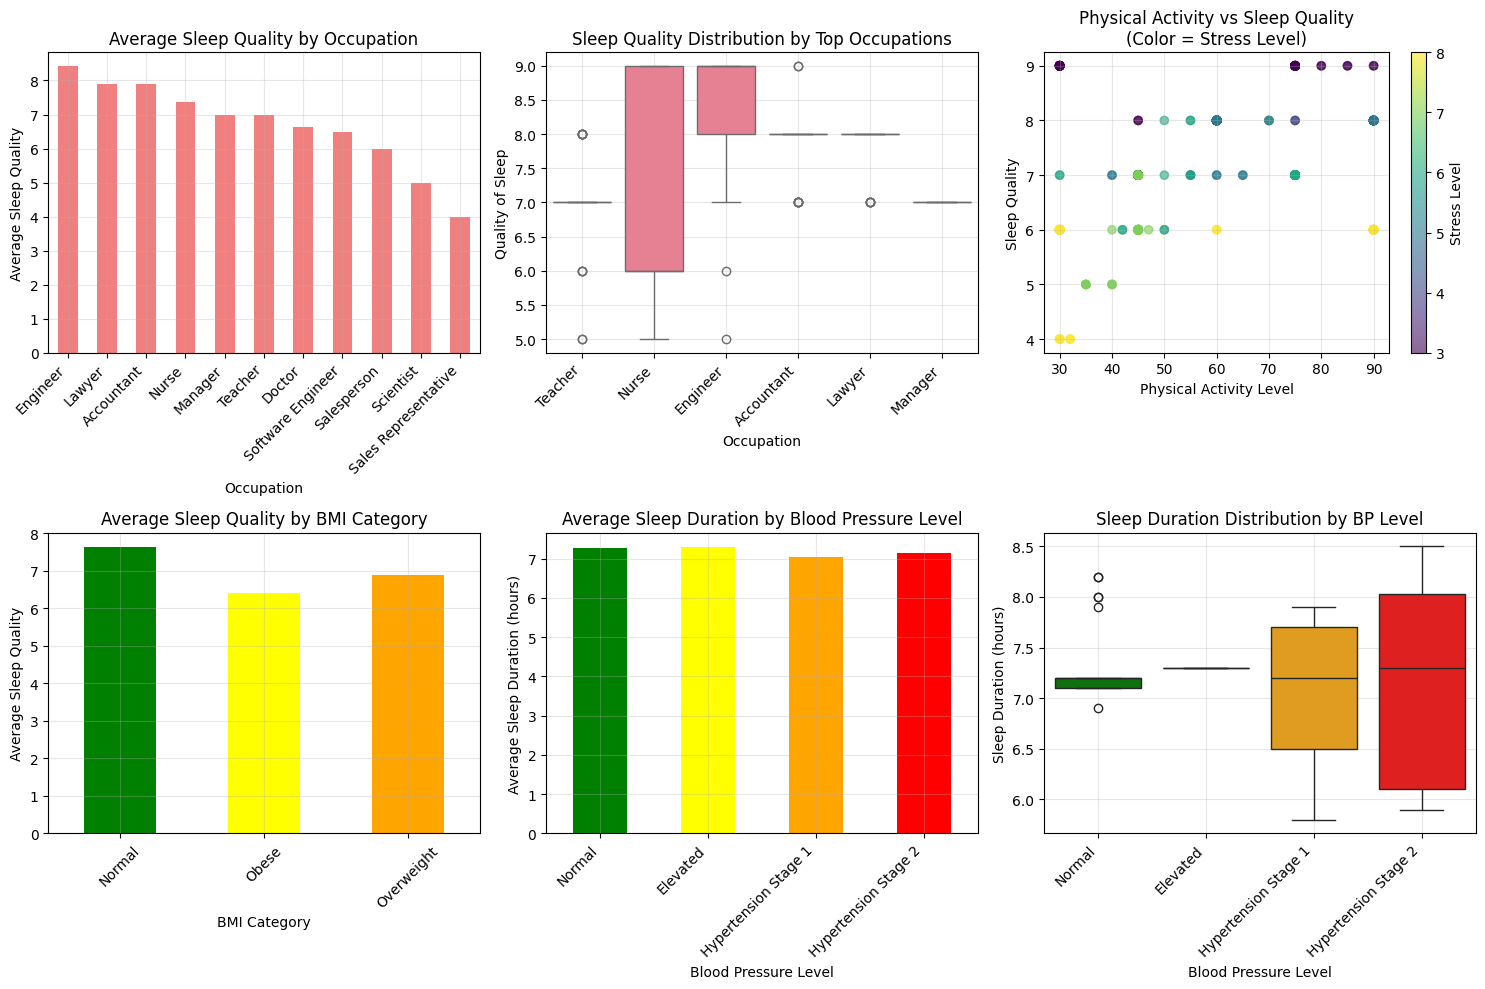

ANOVA F-statistic: 30.0222, p-value: 0.0000

Blood Pressure ANOVA F-statistic: 0.9646, p-value: 0.4095


In [5]:
# Occupation and Sleep Quality Analysis
plt.figure(figsize=(15, 10))

# Top left: Average sleep quality by occupation
plt.subplot(2, 3, 1)
occupation_sleep = df_clean.groupby('Occupation')['Quality of Sleep'].agg(['mean', 'count']).sort_values('mean', ascending=False)
occupation_sleep['mean'].plot(kind='bar', color='lightcoral')
plt.title('Average Sleep Quality by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Average Sleep Quality')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Top middle: Sleep quality distribution by occupation
plt.subplot(2, 3, 2)
top_occupations = occupation_sleep.head(6).index
df_top_occ = df_clean[df_clean['Occupation'].isin(top_occupations)]
sns.boxplot(data=df_top_occ, x='Occupation', y='Quality of Sleep')
plt.title('Sleep Quality Distribution by Top Occupations')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Top right: Physical activity vs sleep quality
plt.subplot(2, 3, 3)
plt.scatter(df_clean['Physical Activity Level'], df_clean['Quality of Sleep'],
           alpha=0.6, c=df_clean['Stress Level'], cmap='viridis')
plt.xlabel('Physical Activity Level')
plt.ylabel('Sleep Quality')
plt.title('Physical Activity vs Sleep Quality\n(Color = Stress Level)')
plt.colorbar(label='Stress Level')
plt.grid(True, alpha=0.3)

# Bottom left: BMI vs sleep quality
plt.subplot(2, 3, 4)
bmi_sleep = df_clean.groupby('BMI Category')['Quality of Sleep'].mean()
bmi_sleep.plot(kind='bar', color=['green', 'yellow', 'orange', 'red'])
plt.title('Average Sleep Quality by BMI Category')
plt.xlabel('BMI Category')
plt.ylabel('Average Sleep Quality')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Bottom middle: Blood Pressure Level vs Sleep Duration
plt.subplot(2, 3, 5)
bp_order = ['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2']
bp_sleep = df_clean.groupby('Blood_Pressure_Level')['Sleep Duration'].mean().reindex(bp_order)
bp_sleep.plot(kind='bar', color=['green', 'yellow', 'orange', 'red'])
plt.title('Average Sleep Duration by Blood Pressure Level')
plt.xlabel('Blood Pressure Level')
plt.ylabel('Average Sleep Duration (hours)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Bottom right: Box plot showing distribution
plt.subplot(2, 3, 6)
sns.boxplot(data=df_clean, x='Blood_Pressure_Level', y='Sleep Duration', 
            order=bp_order, palette=['green', 'yellow', 'orange', 'red'])
plt.title('Sleep Duration Distribution by BP Level')
plt.xlabel('Blood Pressure Level')
plt.ylabel('Sleep Duration (hours)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical analysis of occupation effects
from scipy.stats import f_oneway

occupations = df_clean['Occupation'].unique()
occupation_groups = [df_clean[df_clean['Occupation'] == occ]['Quality of Sleep'].values
                    for occ in occupations]

f_stat, p_value = f_oneway(*occupation_groups)
print(f"ANOVA F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")

# Statistical analysis for Blood Pressure vs Sleep Duration
bp_groups = [df_clean[df_clean['Blood_Pressure_Level'] == bp]['Sleep Duration'].values
             for bp in bp_order if bp in df_clean['Blood_Pressure_Level'].values]

if len(bp_groups) > 1:
    f_stat_bp, p_value_bp = f_oneway(*bp_groups)
    print(f"\nBlood Pressure ANOVA F-statistic: {f_stat_bp:.4f}, p-value: {p_value_bp:.4f}")

# Regression

We chose sleep duration as our response variable, as it numeric and not discrete

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

#  look at correlations to choose a good predictor for sleep duration
corr = df_clean.corr(numeric_only=True)
print(corr["Sleep Duration"].sort_values(ascending=False))

Sleep Duration             1.000000
Quality of Sleep           0.883213
Age                        0.344709
Person ID                  0.296305
Physical Activity Level    0.212360
Daily Steps               -0.039533
Has_Sleep_Apnea           -0.064626
Diastolic_BP              -0.166570
Systolic_BP               -0.180406
Has_Insomnia              -0.347618
BMI_Numeric               -0.349605
Heart Rate                -0.516455
Stress Level              -0.811023
Has_Sleep_Disorder              NaN
Name: Sleep Duration, dtype: float64


We decided to do stress level as our predictor variable as it has a strong negative correlation with Sleep Duration

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



In [8]:
traindf, testdf = train_test_split(df_clean, test_size=0.2, random_state=42)


# training arrays
y_train = np.array(traindf['Sleep Duration'])  # response variable
X_train = np.array(traindf['Stress Level'])   # predictor variable
X_train = X_train.reshape(X_train.shape[0], 1) # reshape to 2D array for sklearn

In [ ]:
y_test = np.array(testdf['Sleep Duration'])  # response variable
X_test = np.array(testdf['Stress Level'])   # predictor variable
X_test = X_test.reshape(X_test.shape[0], 1) # reshape to 2D array for sklearn


In [10]:
y_train.shape, X_train.shape, y_test.shape, X_test.shape

((299,), (299, 1), (75,), (75, 1))

In [11]:
#create linear model
regression = LinearRegression()

#fit linear model
regression.fit(X_train, y_train)

predicted_y = regression.predict(X_test)

r2 = regression.score(X_test, y_test)
print(f'R^2 = {r2:.5}')

R^2 = 0.71067


In [ ]:
# Calculate proper evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score

# Predictions for both train and test sets
y_train_pred = regression.predict(X_train)
y_test_pred = regression.predict(X_test)

# R^2 scores
train_r2 = regression.score(X_train, y_train)
test_r2 = regression.score(X_test, y_test)

# MSE scores
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# RMSE scores
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print("Evaluation Metrics: ")
print(f"Training R^2: {train_r2:.4f}")
print(f"Test R^2: {test_r2:.4f}")
print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")



print(f"\nModel coefficients:")
print(f"Slope: {regression.coef_[0]:.4f}")
print(f"Intercept: {regression.intercept_:.4f}")

Evaluation Metrics: 
Training R²: 0.6416
Test R²: 0.7107
Training MSE: 0.2221
Test MSE: 0.1926
Training RMSE: 0.4713
Test RMSE: 0.4389

Model coefficients:
Slope: -0.3572
Intercept: 9.0532


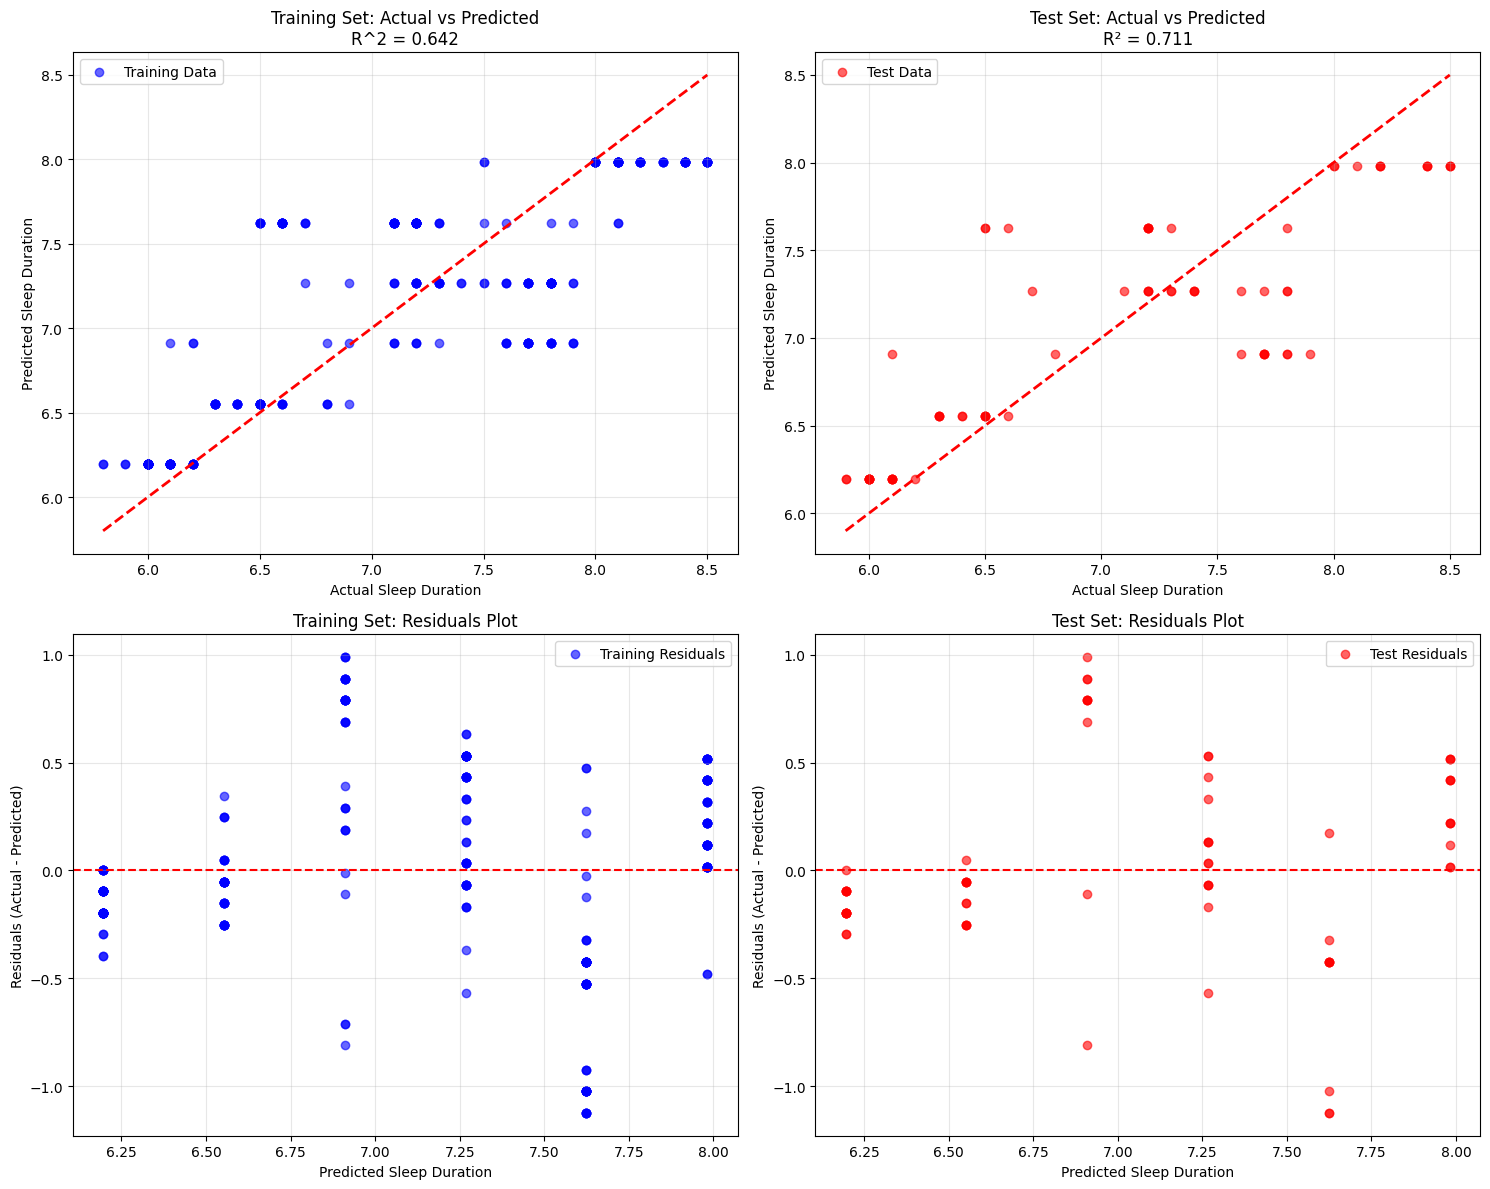

Training R^2: 0.6416
Test R^2: 0.7107


In [ ]:
# Visualization to check for overfitting/underfitting
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted for Training Set
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.6, color='blue', label='Training Data')
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Sleep Duration')
axes[0, 0].set_ylabel('Predicted Sleep Duration')
axes[0, 0].set_title(f'Training Set: Actual vs Predicted\nR^2 = {train_r2:.3f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted for Test Set
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.6, color='red', label='Test Data')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Sleep Duration')
axes[0, 1].set_ylabel('Predicted Sleep Duration')
axes[0, 1].set_title(f'Test Set: Actual vs Predicted\nR² = {test_r2:.3f}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals Plot for Training Set
train_residuals = y_train - y_train_pred
axes[1, 0].scatter(y_train_pred, train_residuals, alpha=0.6, color='blue', label='Training Residuals')
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Predicted Sleep Duration')
axes[1, 0].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 0].set_title('Training Set: Residuals Plot')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuals Plot for Test Set
test_residuals = y_test - y_test_pred
axes[1, 1].scatter(y_test_pred, test_residuals, alpha=0.6, color='red', label='Test Residuals')
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Predicted Sleep Duration')
axes[1, 1].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 1].set_title('Test Set: Residuals Plot')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Performance comparison
print(f"Training R^2: {train_r2:.4f}")
print(f"Test R^2: {test_r2:.4f}")

There is no evidence of overfitting, as both the train and test data perform relatively the same, with the test set performing better and having a lower MSE. There is evidence of slight underfitting, since the training R^2 of 0.64 shows the model doesn't perfectly capture all the patterns in the training data.

### Regularization

In [32]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler

In [36]:

# Select multiple columns using list syntax (square brackets, not parentheses)
X = df_clean[['Stress Level', 'Age', 'Heart Rate', 'Has_Sleep_Disorder', 'Has_Sleep_Apnea', 'Has_Insomnia']]
y = df_clean['Sleep Duration']

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Sapply the  scaling to test data
X_test_scaled = scaler.transform(X_test)


Best alpha: 2.5950
Best CV RMSE: 0.6472


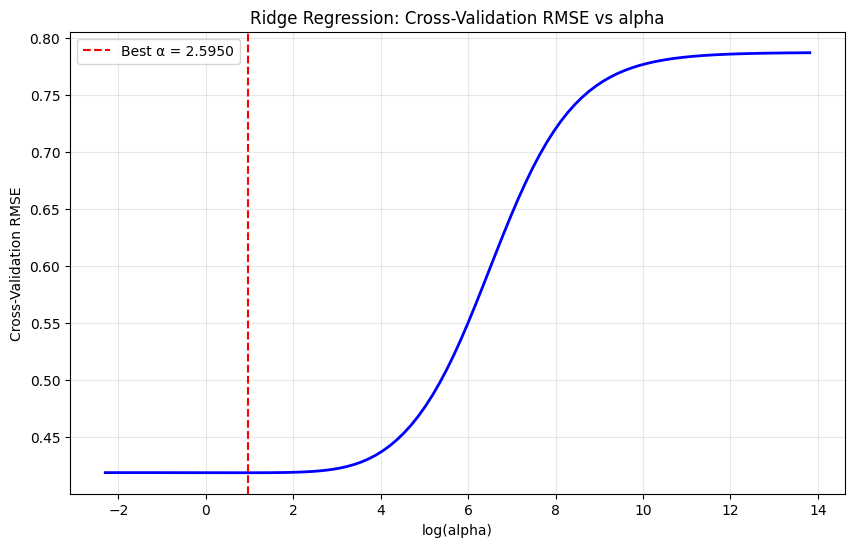

In [40]:
# use 10-fold cross-validation to select the best lambda (alpha) value for the ridge regression model

# define the alpha values to test
# note that the start/stop values in the first two arguments are the exponents
alphas = np.logspace(-1, 6, 100)

# create an empty list to store the cross-validation scores
ridge_cv_scores = []

# create a for loop to compute the cross-validation score for each alpha value
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge_cv = cross_validate(estimator=ridge,
                              X=X_train_scaled,  
                              y=y_train,         
                              cv=10,
                              scoring='neg_root_mean_squared_error')
    ridge_cv_scores.append({'alpha': alpha,
                            'log_alpha': np.log(alpha),
                            'test_mse': -np.mean(ridge_cv['test_score'])})

# convert the cross-validation scores into a data frame
ridge_cv_scores_df = pd.DataFrame(ridge_cv_scores)

# Find the best alpha
best_alpha_idx = ridge_cv_scores_df['test_mse'].idxmin()
best_alpha = ridge_cv_scores_df.loc[best_alpha_idx, 'alpha']
best_mse = ridge_cv_scores_df.loc[best_alpha_idx, 'test_mse']

print(f"Best alpha: {best_alpha:.4f}")
print(f"Best CV RMSE: {np.sqrt(best_mse):.4f}")

# plot the cross-validation scores as a function of alpha
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(ridge_cv_scores_df['log_alpha'], ridge_cv_scores_df['test_mse'], 'b-', linewidth=2)
plt.axvline(x=np.log(best_alpha), color='r', linestyle='--', label=f'Best α = {best_alpha:.4f}')
plt.xlabel('log(alpha)')
plt.ylabel('Cross-Validation RMSE')
plt.title('Ridge Regression: Cross-Validation RMSE vs alpha')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Final Ridge Regression Results:
Best lambda (alpha): 2.5950
Training R^2: 0.7233
Test R^2: 0.7644
Training RMSE: 0.4142
Test RMSE: 0.3961

Model coefficients:
Stress Level: -0.5810
Age: 0.1280
Heart Rate: 0.0834
Has_Sleep_Disorder: 0.0000
Has_Sleep_Apnea: -0.1591
Has_Insomnia: -0.2452
Intercept: 7.1562


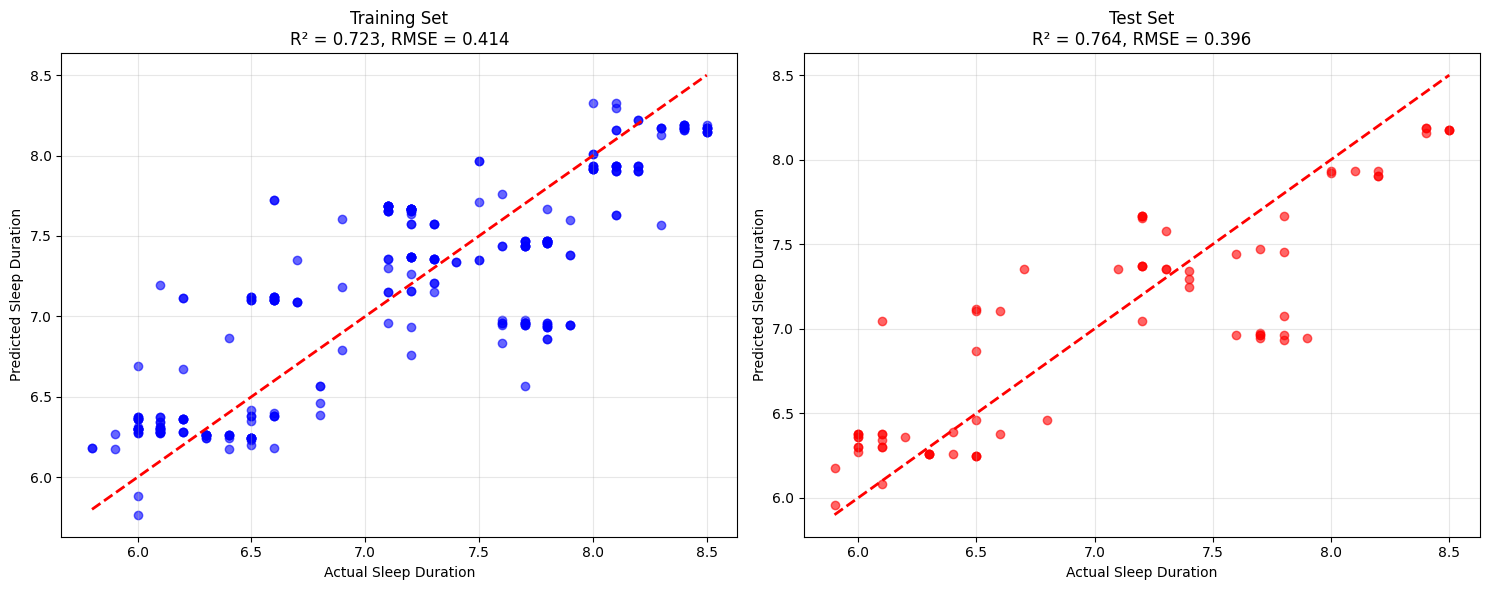

In [41]:
# train the final model with the best alpha
final_ridge = Ridge(alpha=best_alpha)
final_ridge.fit(X_train_scaled, y_train)

# Make predictions on both training and test sets
y_train_pred = final_ridge.predict(X_train_scaled)
y_test_pred = final_ridge.predict(X_test_scaled)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Final Ridge Regression Results:")
print(f"Best lambda (alpha): {best_alpha:.4f}")
print(f"Training R^2: {train_r2:.4f}")
print(f"Test R^2: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Display coefficients
feature_names = ['Stress Level', 'Age', 'Heart Rate', 'Has_Sleep_Disorder', 'Has_Sleep_Apnea', 'Has_Insomnia']
print(f"\nModel coefficients:")
for name, coef in zip(feature_names, final_ridge.coef_):
    print(f"{name}: {coef:.4f}")
print(f"Intercept: {final_ridge.intercept_:.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.6, color='blue')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Sleep Duration')
axes[0].set_ylabel('Predicted Sleep Duration')
axes[0].set_title(f'Training Set\nR² = {train_r2:.3f}, RMSE = {train_rmse:.3f}')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred, alpha=0.6, color='red')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Sleep Duration')
axes[1].set_ylabel('Predicted Sleep Duration')
axes[1].set_title(f'Test Set\nR² = {test_r2:.3f}, RMSE = {test_rmse:.3f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


We chose a few more predictor variables and used Ridge Regression to adjust the coefficients, reducing the impact of less important features. 